In [1]:
doc = """
    This file contains the real implementation for decoding the images. 
    
    The other file, AllAtOnce_ConvNet was used for data preparation.
"""

In [2]:
## import libraries

import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import math
import os
import pylab as P
import skimage
import h5py
import PIL.Image as Image
import functools
from sklearn.cross_validation import train_test_split as ttsplit
import cPickle as pickle

In [3]:
#set the random seed so that we get consistent results across runs
tf.set_random_seed(1234)

In [4]:
# helpers to read files off the disk
## TODO: move helpers to their own module

def read_pickle(f_name):
    f = open(f_name, 'r')
    return pickle.load(f)

data_path = os.path.join(os.path.split(os.getcwd())[0], 'data')

def get_data_path(f_name):
    return os.path.join(data_path, f_name)

In [5]:
# read the data off the disk

bundles = [read_pickle(get_data_path(f_name)) for f_name in ['train_images.pkl', 'test_images.pkl', 'valid_images.pkl']]
train_bundle, test_bundle, valid_bundle = bundles

train_images = train_bundle['X']
test_images = test_bundle['X']
valid_images = valid_bundle['X']

train_labels = train_bundle['y']
test_labels = test_bundle['y']
valid_labels = valid_bundle['y']
        

In [6]:
## let's carry out some exploratory analysis
## let's plagiarise our plot code from the other file
## TODO: figure out if ipynb can import other ipynb. actually, no. move code to .py

labels = range(11)

def plot_label_data(x,y, name, x_label, y_label, width=1./3, color='blue'):
    plt.bar(x, y, width = width, color = color)
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    


def plot_label_distribution(label_data, name):
    sizes = np.array([len(np.where(label_data==l)[0]) for l in labels], dtype=np.float32)
    print sizes/sum(sizes)
    plot_label_data(labels, sizes, name, 'Digits', 'Frequency')
        


[ 0.02224263  0.09669932  0.15948628  0.06329712  0.03403989  0.03043057
  0.02521426  0.02574992  0.02117131  0.02034231  0.50132638]


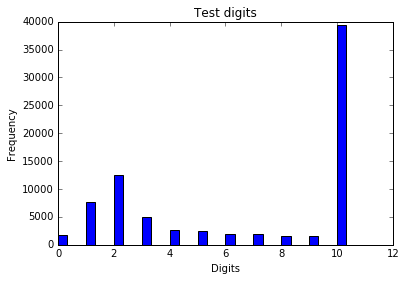

[ 0.03597106  0.08391263  0.12338489  0.13160102  0.05236414  0.04295241
  0.0335356   0.03520131  0.02867919  0.02772808  0.40466967]


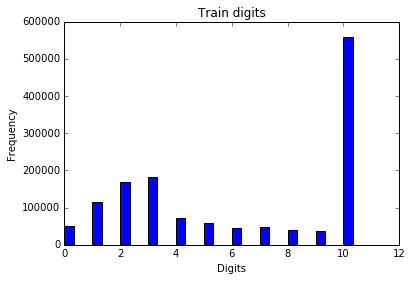

[ 0.02534728  0.09070784  0.14137474  0.09253418  0.04659915  0.03566882
  0.02999613  0.02963639  0.02410205  0.02476617  0.45926726]


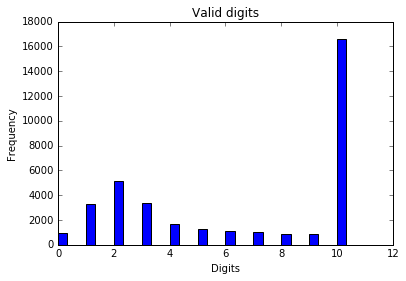

In [7]:
plot_label_distribution(test_labels, 'Test digits')
plot_label_distribution(train_labels, 'Train digits')
plot_label_distribution(valid_labels, 'Valid digits')


Extremely interesting that Benford's law has been abandoned here. 

Obviously, 
- the cropped images and the full images are not the same
- the 10 stands for the blank and it is natural that it appears so frequently

In [8]:
## plot distributions of lengths
from collections import Counter

def get_lengths(label_data):
    return map(lambda row: len(np.where(row != 10)[0]), label_data)

## check how many of each kind we have
def count_distribution(label_data):
    lengths = get_lengths(label_data)
    return Counter(length)

def plot_count_distribution(label_data, name):
    
    print len(label_data)
    counts = Counter(label_data)
    keys  = counts.keys()
    sizes = counts.values()
    
    print counts.keys()
    print counts.values()
    assert(sum(counts.values()) == len(label_data))
    plot_label_data(keys, sizes, name, 'Sizes', 'Frequency', width = 2./3)



229731
[1, 2, 3, 4, 5]
[13681, 86714, 113711, 15503, 122]


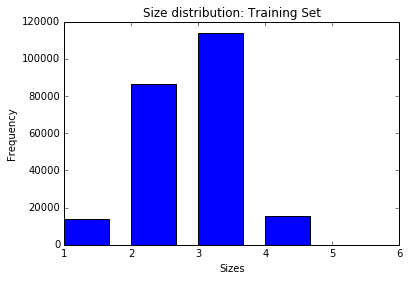

6023
[1, 2, 3, 4, 5]
[841, 3142, 1769, 269, 2]


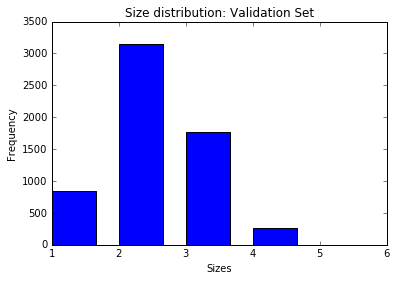

13068
[1, 2, 3, 4, 5]
[2483, 8356, 2081, 146, 2]


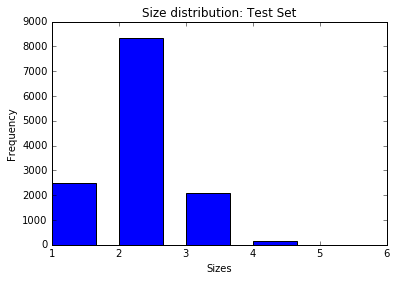

In [9]:
plot_count_distribution(train_labels[:,0], "Size distribution: Training Set")
plot_count_distribution(valid_labels[:,0], "Size distribution: Validation Set")
plot_count_distribution(test_labels[:,0], "Size distribution: Test Set")

# Let's try some learning

In [10]:
#define an accuracy measure for this model
def accuracy(predictions, labels):
    """
        How many places did we get right?
    """
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels)) / labels.size

In [11]:
## we use 64 images at a time
batch_size = 64

# each image is image_size x image_size and has one channel
image_size = 32
num_channels = 1

# convolve layers -> we convolve with a 5x5 patch and increase the depth as we go along
patch_size = 5

## first, we get to a depth of 16 at the end of one stage of convolution
depth1 = 16

# then we proceed to a depth of 32 for the convolved data
depth2 = 32


## droput probability of 0.99 to regularize the network
keep_prob_dropout = 0.99

## Fully connected network at the end
num_hidden = 64

# each of our variables can be either of 11 values
num_labels = 11 ## 10 digits (0-9) + we have a blank space

# create a tensorflow graph
graph = tf.Graph()

## use this graph

with graph.as_default():

  # Input data.
  # train data
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

  ## test and validation data
  tf_valid_dataset = tf.constant(valid_images)
  tf_test_dataset = tf.constant(test_images)
  
  # Variables.
  ## convolution layer 1
  layer1_weights = tf.get_variable("conv1",
                                   shape = [patch_size, patch_size, num_channels, depth1],
                                   initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                  )
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  
  ## convolution layer 2
  layer2_weights = tf.get_variable("conv2",
                                   shape = [patch_size, patch_size, depth1, depth2],
                                   initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                  )
  layer2_biases = tf.Variable(tf.zeros([depth2]))

  ## hidden layer
  layer3_weights = tf.Variable(tf.truncated_normal(
    [patch_size * patch_size * depth2, num_hidden], stddev=0.1)) 
  layer3_biases = tf.Variable(tf.zeros([num_hidden]))

  ## 5 predictors here for the five places
  ## op layer
  op1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

  op5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  op5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))


  # The actual model
  def model(data, is_training = False):
    
    ## convolve the input data
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID') # -> 28x28x1x16
    
    ## pool it using max_pool
    pool = tf.nn.max_pool(conv, [1, 2, 2, 1], [1,2,2,1], padding = 'SAME') ## 
    
    ## pass it through a relu to let the positive signals through
    hidden = tf.nn.relu(pool + layer1_biases)
    
    ## repeat the same all over
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding = 'SAME')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    ## pass this to the hidden layer
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    
    ## use dropouts (but only if training)
    if is_training:
        hidden  = tf.nn.dropout(hidden, keep_prob=keep_prob_dropout)

    ## predict the outputs using the op projection layers
    digit_1 = tf.matmul(hidden, op1_weights) + op1_biases
    digit_2 = tf.matmul(hidden, op2_weights) + op2_biases
    digit_3 = tf.matmul(hidden, op3_weights) + op3_biases
    digit_4 = tf.matmul(hidden, op4_weights) + op4_biases
    digit_5 = tf.matmul(hidden, op5_weights) + op5_biases
    
    # return the predicted outputs
    return (digit_1, digit_2, digit_3, digit_4, digit_5)

  # Get the output from the model function
  d1, d2, d3, d4, d5 = model(tf_train_dataset, True)

  # Compute the loss -> the average loss for each digit
  loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(d1, tf_train_labels[:,1])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, tf_train_labels[:,2])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, tf_train_labels[:,3])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, tf_train_labels[:,4])
     +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, tf_train_labels[:,5])
    )
    
  # Optimize this loss
  global_step = tf.Variable(0)  # count the number of steps taken.
  # set the learning the rate as variable
  learning_rate = tf.train.exponential_decay(0.08, global_step, 2500, 0.98)
    
  ## define the optimization function
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
  optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.FtrlOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)  

  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])
  valid_model  = model(tf_valid_dataset)
  valid_prediction = tf.pack([tf.nn.softmax(valid_model[idx]) for idx in range(5)]) #d in [valid_model]])
  test_model  = model(tf_test_dataset)
  test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])

In [12]:
#run this for 150k steps
num_steps = 50001

# define a tensorflow session
with tf.Session(graph=graph) as session:
  # initialize variables
  tf.initialize_all_variables().run()
  print('Initialized')

  for step in range(num_steps):
    # prepare feed data
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_images[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    ## get the output
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,1:6]))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels[:,1:6]))

  # calculate final results
  final_predictions = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(final_predictions, test_labels[:,1:6]))

Initialized
Minibatch loss at step 0: 12.227589
Minibatch accuracy: 5.3%
Validation accuracy: 6.8%
Minibatch loss at step 2500: 1.310495
Minibatch accuracy: 92.8%
Validation accuracy: 90.2%
Minibatch loss at step 5000: 1.202543
Minibatch accuracy: 93.1%
Validation accuracy: 91.3%
Minibatch loss at step 7500: 0.797610
Minibatch accuracy: 95.9%
Validation accuracy: 92.3%
Minibatch loss at step 10000: 1.060621
Minibatch accuracy: 94.1%
Validation accuracy: 92.4%
Minibatch loss at step 12500: 0.984125
Minibatch accuracy: 95.3%
Validation accuracy: 92.6%
Minibatch loss at step 15000: 1.009935
Minibatch accuracy: 94.7%
Validation accuracy: 92.6%
Minibatch loss at step 17500: 0.808102
Minibatch accuracy: 95.6%
Validation accuracy: 92.8%
Minibatch loss at step 20000: 0.532251
Minibatch accuracy: 96.9%
Validation accuracy: 93.1%
Minibatch loss at step 22500: 0.467357
Minibatch accuracy: 97.2%
Validation accuracy: 92.9%
Minibatch loss at step 25000: 1.082335
Minibatch accuracy: 94.7%
Validation 

94.6 is not too bad!

In [14]:
# how did we do at decoding entire strings?
def whole_string_accuracy(predictions, labels):
    """
        How many strings did we get entirely right?
    """
    ## compare a row at a time
    equal_rows = [np.all(predictions[idx,:] == labels[idx,:]) for idx in range(labels.shape[0])]
    return (100.0 * np.sum(equal_rows))/ labels.shape[0]

In [15]:
predictions = np.argmax(final_predictions, 2).T
print whole_string_accuracy(predictions, test_labels[:,1:6])

78.6883991429


Clearly there is a considerable distance to go as far as improvement is concerned!

In [16]:
def display_images(images, labels, rand_indices=None):
    """
        Display random images from a set and return indices so we can match the results
    """
    display_size = 10
    display_per_row = 10
    num_rows = display_size/display_per_row
    if rand_indices is None:
        rand_indices = np.random.randint(0, test_images.shape[0], size=display_size)
    row_size = 20
    col_size = 20

    fig = P.figure(figsize=(20, 20))
    for idx in range(len(rand_indices)):
        orig_idx = rand_indices[idx]
        display_row_idx = int(idx/display_per_row) + 1
        display_col_idx = idx%display_per_row +1
        a=fig.add_subplot(display_row_idx, display_per_row, display_col_idx, frameon=False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
        a.imshow(images[orig_idx,:,:,0].T, cmap="Greys_r")
        img_label = labels[orig_idx,:]
        a.set_title(''.join([str(x) for x in img_label[img_label != 10]]))
    
    return rand_indices

array([ 4227,  4634,  9432,  2865,  4222,  3255,   973,   292, 12130,  5556])

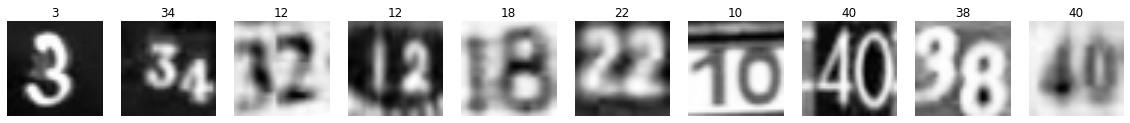

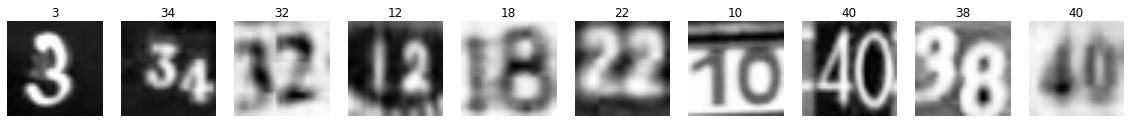

In [17]:
# display some predictions
chosen_images = display_images(test_images, predictions)
# display the originals too
display_images(test_images, test_labels[:,1:], chosen_images)

In [18]:
## calculate f1 score of all 11 classes in the data
from sklearn.metrics import f1_score

## reshape the predictions and outputs
test_labels_reshape = test_labels[:,1:6].reshape(-1,1)
predictions_reshape = predictions.reshape(-1, 1)

## Exclude the blank spaces when determining F1 scores
actual_digit_labels = range(10)
f1_weighted = f1_score(test_labels_reshape, predictions_reshape, actual_digit_labels, average='weighted')
f1_unweighted = f1_score(test_labels_reshape, predictions_reshape, actual_digit_labels, average='macro')
f1_scores  = f1_score(test_labels_reshape, predictions_reshape, actual_digit_labels, average=None)

print "Weighted F1: ", f1_weighted
print "Unweighted F1: ", f1_unweighted

print "Classwise F1"
for k,v in zip(labels, f1_scores):
    print "\tDigit: {}, f1: {}".format(k,v)

Weighted F1:  0.871878610794
Unweighted F1:  0.861645979083
Classwise F1
	Digit: 0, f1: 0.853414769572
	Digit: 1, f1: 0.904058313633
	Digit: 2, f1: 0.902600588813
	Digit: 3, f1: 0.844329004329
	Digit: 4, f1: 0.899212598425
	Digit: 5, f1: 0.878607809847
	Digit: 6, f1: 0.835897435897
	Digit: 7, f1: 0.864094372082
	Digit: 8, f1: 0.819053510671
	Digit: 9, f1: 0.81519138756


In [19]:
# check the accuracy wrt number of digits in the outcome
predicted_lengths = get_lengths(predictions)

valid_lengths = range(1,6)


f1_l_weighted = f1_score(test_labels[:,0], predicted_lengths, valid_lengths, average='weighted')
f1_l_unweighted = f1_score(test_labels[:,0], predicted_lengths, valid_lengths, average='macro')
f1_l_scores  = f1_score(test_labels[:,0], predicted_lengths, valid_lengths, average=None)

/home/ag/bin/py/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
print "Weighted F1: ", f1_l_weighted
print "Unweighted F1: ", f1_l_unweighted

print "Classwise F1"
for k,v in zip(valid_lengths, f1_l_scores):
    print "\tDigit: {}, f1: {}".format(k,v)

Weighted F1:  0.947361649581
Unweighted F1:  0.732013463657
Classwise F1
	Digit: 1, f1: 0.935305719921
	Digit: 2, f1: 0.961736081726
	Digit: 3, f1: 0.911674165285
	Digit: 4, f1: 0.851351351351
	Digit: 5, f1: 0.0


This is terrible - we messed up both the examples with 5 digits in them and that messed up our overall F1 score!

Clean up the code to make it like a sklearn model.

This will enable us to use sklearn primitives.

## The Final Cut

Create a Model class that behaves like an SKLearn class. This will help us run meaningful validations without having to change the code manually each time. We can generalize it later.

In [39]:
from sklearn.base import BaseEstimator

PARAM_ALPHA_NAME = 'alpha'
PARAM_OPTIMIZER_NAME = 'optimizer'
PARAM_OPTIMIZER_VAL_GRADIENT_DESCENT = 'GradientDescent'
PARAM_OPTIMIZER_VAL_ADAM = 'Adam'

class SVHNModel(BaseEstimator):
    def get_params(self, deep=False):
        """
            We currently support alpha and optimizer
        """
        return {PARAM_ALPHA_NAME: self.alpha, PARAM_OPTIMIZER_NAME: self._opt}
    
    
    def set_params(self, **d):
        if 'optimizer' in d:
            self.optimizer = d['optimizer']
        if 'alpha' in d:
            self.alpha  = d['alpha']

    
    # Model.
    def model(self, data, is_training = False):
        with self.graph.as_default():
            conv = tf.nn.conv2d(data, self.layer1_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.avg_pool(conv, [1, 2, 2, 1], [1,2,2,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer1_biases)
            shape = hidden.get_shape().as_list()
            #print shape

            conv = tf.nn.conv2d(hidden, self.layer2_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer2_biases)
            shape = hidden.get_shape().as_list()
            #print shape
            
            conv = tf.nn.conv2d(hidden, self.layer2_5_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.max_pool(conv, [1,3,3,1], [1,3,3,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer2_5_biases)
            
            shape = hidden.get_shape().as_list()
            #print shape
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden1 = tf.nn.relu(tf.matmul(reshape, self.layer3_weights) + self.layer3_biases)
            
            if is_training:
                hidden1  = tf.nn.dropout(hidden1, keep_prob=self._keep_prob_dropout)
        
            hidden = tf.nn.relu(tf.matmul(hidden1, self.layer3_5_weights) + self.layer3_5_biases)
            if is_training:
                hidden  = tf.nn.dropout(hidden, keep_prob=self._keep_prob_dropout)
                
            digit_1 = tf.matmul(hidden, self.op1_weights) + self.op1_biases
            digit_2 = tf.matmul(hidden, self.op2_weights) + self.op2_biases
            digit_3 = tf.matmul(hidden, self.op3_weights) + self.op3_biases
            digit_4 = tf.matmul(hidden, self.op4_weights) + self.op4_biases
            digit_5 = tf.matmul(hidden, self.op5_weights) + self.op5_biases

            return (digit_1, digit_2, digit_3, digit_4, digit_5)

    
    def __init__(self,
                 graph=None,
                 session=None,
                 verbose  = True,
                 alpha = 0.08,
                 decay_rate = 0.95,
                 decay_epochs = 1,
                 optimizer = tf.train.GradientDescentOptimizer,
                 keep_prob_dropout = 0.99,
                 batch_size = 64,
                 train_epochs = 30
                ):
        
        image_size=32
        num_channels = 1
        patch_size = 5
        patch_size2 = 3
        depth1 = 16
        depth2 = 32
        depth3  = 64
        num_hidden1 = 64
        num_hidden = num_hidden2  = 32
        num_labels = 11
        
        # intialize some of these variables
        self.verbose = verbose
        self._alpha = alpha
        self._opt = optimizer
        self._decay_rate = decay_rate
        self._decay_epochs  = decay_epochs
        self._keep_prob_dropout = keep_prob_dropout
        self._batch_size = batch_size
        self._train_epochs = train_epochs
        self._optimizer = None
        
        ## delve into the graph
        self.graph = graph
        self.session = session
            
        # Input data.
        self.tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        self.tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
        
          # Variables.
          # Layer 1 - convolutional layer
        self.layer1_weights = tf.get_variable("conv1",
                                           shape = [patch_size, patch_size, num_channels, depth1],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer1_biases = tf.Variable(tf.zeros([depth1]))


        # Layer 2 - convolutional layer
        self.layer2_weights = tf.get_variable("conv2",
                                           shape = [patch_size, patch_size, depth1, depth2],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer2_biases = tf.Variable(tf.zeros([depth2]))

        
        # Layer 2.5 - convolutional layer
        self.layer2_5_weights = tf.get_variable("conv2_5",
                                           shape = [patch_size2, patch_size2, depth2, depth3],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer2_5_biases = tf.Variable(tf.zeros([depth3]))

        
          # Layer 3 - hidden layer
        self.layer3_weights = tf.Variable(tf.truncated_normal(
            [1 * 1 * depth3, num_hidden1], stddev=0.1))
        self.layer3_biases = tf.Variable(tf.zeros([num_hidden1]))
        
        self.layer3_5_weights = tf.Variable(tf.truncated_normal(
            [num_hidden1, num_hidden2], stddev=0.1))
        self.layer3_5_biases = tf.Variable(tf.zeros([num_hidden2]))
        

          ## Outputs- projection for each digit
        self.op1_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
        self.op1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op2_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
        self.op2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op3_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op4_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op5_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        
          # Training computation.
        d1, d2, d3, d4, d5 = self.model(self.tf_train_dataset, True)
        self.loss = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(d1, self.tf_train_labels[:,1])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, self.tf_train_labels[:,2])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, self.tf_train_labels[:,3])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, self.tf_train_labels[:,4])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, self.tf_train_labels[:,5])
            )

          # Optimizer.
          # So confusing to track lr and alpha
          # use lr when dealing within tf land 
          # use alpha to communicate with outside world
        self._lr = tf.Variable(0.0, trainable = False) 
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._tf_lr_update = tf.assign(self._lr, self._new_lr)
          
        self.optimizer = optimizer
          #print self._optimizer #self._opt(self._lr)
          
          # Predictions for the training, validation, and test data.
        self.train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])

    
    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, _lr):
        ## this requires a retrain
        ## reinit all variables, et al?
        self.session.run(self._tf_lr_update, feed_dict={self._new_lr: _lr})
    
    @property
    def optimizer(self):
        return self._opt

    @optimizer.setter
    def optimizer(self, opt):
        ## this requires a retrain
        ## reinit all variables, et al?
        self._opt = opt
        self._optimizer = opt(self._lr).minimize(self.loss)

    
    def fit(self, train_images, train_labels):
          """
            X: train_images
            y: train_labels
          """
        ## calc num steps per epoch
          num_steps = train_labels.shape[0]/self._batch_size - 1
        
        # run the session
        #with tf.Session(graph=self.graph) as session: #self.session.as_default():
          tf.initialize_all_variables().run()
          if self.verbose:
              print('Initialized variables, fitting data')
            
          for epoch_id in range(self._train_epochs):
            lr_decay = self._decay_rate ** (epoch_id/self._decay_epochs)
            lr_rate = self._alpha * lr_decay
            self.alpha = lr_rate
              
            for step in range(num_steps):
                offset = (step * self._batch_size) % (train_labels.shape[0] - self._batch_size)
                batch_data = train_images[offset:(offset + batch_size), :, :, :]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {self.tf_train_dataset : batch_data, self.tf_train_labels : batch_labels}
                _, l, predictions = self.session.run(
                  [self._optimizer, self.loss, self.train_prediction], feed_dict=feed_dict)
                if self.verbose and (step % 2500 == 0):
                  print('Minibatch loss at epoch: %d, step %d: %f' % (epoch_id, step, l))
                  print('Minibatch F1: %0.3f' % self.measure_score(batch_labels[:,1:6], np.argmax(predictions, 2).T))


    def predict(self, test_images):
        test_dataset = tf.constant(test_images)
        test_model  = self.model(test_dataset)
        test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])
        predicted_labels = self.session.run(test_prediction)
        return np.argmax(predicted_labels,2).T
    
    def measure_score(self, true_labels, predicted_labels, average = 'weighted'):
        ## reshape the labels 
        predicted_labels_1d = predicted_labels.reshape(-1,1)
        true_labels_1d = true_labels.reshape(-1,1)
        return f1_score(true_labels_1d, predicted_labels_1d, labels=range(11), average=average)
    
    def score(self, test_images, test_labels, average = 'weighted'):
        predicted_labels = self.predict(test_images)
        return self.measure_score(test_labels, predicted_labels, average)
        

In [24]:
## With that out of the way, our code should be pretty concise now!
graph = tf.Graph()
with graph.as_default(), tf.Session() as session:
    svhn_model = SVHNModel(graph, session, train_epochs=1)
    svhn_model.fit(train_images, train_labels)
    f1 = svhn_model.score(test_images, test_labels[:,1:6])
    print f1

[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
Initialized variables, fitting data
Minibatch loss at epoch: 0, step 0: 11.930097
Minibatch F1: 0.142
Minibatch loss at epoch: 0, step 2500: 2.990092
Minibatch F1: 0.828
[13068, 14, 14, 16]
[13068, 5, 5, 32]
[13068, 1, 1, 64]
0.880001022324


**Note: The bits above worked. Sadly, GridSearchCV does a deep copy for some reason which will not sit well with what we are trying. Write the validation code manually**

In [25]:
from sklearn.grid_search import GridSearchCV
## TODO: GridSearchCV needs objects to be deep-copyable -> in a rather brutish way
## so, let's soldier on with what we have and implement grid search cv ourselves

from itertools import product
hyperparams = {
                    PARAM_ALPHA_NAME: [0.08, 0.12, 0.15],
                    PARAM_OPTIMIZER_NAME: [tf.train.GradientDescentOptimizer, tf.train.AdadeltaOptimizer]
              }

params_to_try = hyperparams.keys()

Rather ironic that while looking for possible solutions to the problem of using GridSearch along with Tensorflow, i found skflow and that skflow has been included in the TensorFlow library already. It would have saved a whole lot of time and effort to use it from the beginning.

In [26]:
## generate the possible combinations as a cartesian product of the hyperparams
possible_combinations = product(hyperparams[PARAM_ALPHA_NAME], hyperparams[PARAM_OPTIMIZER_NAME])
results = {}
for combination in possible_combinations:
    ## reformulate the product as a dictionary
    kw_args = dict(zip(params_to_try, combination))
    
    ## create and run the model
    graph = tf.Graph()
    with graph.as_default(), tf.Session() as session:
        svhn_model = SVHNModel(graph, session, train_epochs=10, verbose=False, **kw_args)
        svhn_model.fit(train_images, train_labels)
        score = svhn_model.score(valid_images, valid_labels[:,1:6])
        results[score] = kw_args

[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[6023, 14, 14, 16]
[6023, 5, 5, 32]
[6023, 1, 1, 64]
[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[6023, 14, 14, 16]
[6023, 5, 5, 32]
[6023, 1, 1, 64]
[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[6023, 14, 14, 16]
[6023, 5, 5, 32]
[6023, 1, 1, 64]
[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[6023, 14, 14, 16]
[6023, 5, 5, 32]
[6023, 1, 1, 64]
[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[6023, 14, 14, 16]
[6023, 5, 5, 32]
[6023, 1, 1, 64]
[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[6023, 14, 14, 16]
[6023, 5, 5, 32]
[6023, 1, 1, 64]


In [27]:
#print results
best_result = sorted(results.keys())[-1]
print best_result, results[best_result]

0.926084812238 {'alpha': 0.08, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>}


In [28]:
# create an SVHN model with the params we found and use this on the test set
graph = tf.Graph()
with graph.as_default(), tf.Session() as session:
    best_svhn_model = SVHNModel(graph, session, train_epochs=50, verbose=False, **results[best_result])
    best_svhn_model.fit(train_images, train_labels)
    predicted_labels = best_svhn_model.predict(test_images)
    print best_svhn_model.measure_score(test_labels[:,1:6], predicted_labels)
    print best_svhn_model.measure_score(test_labels[:,1:6], predicted_labels, average=None)
    print best_svhn_model.measure_score(test_labels[:,1:6], predicted_labels, average = 'macro')

[64, 14, 14, 16]
[64, 5, 5, 32]
[64, 1, 1, 64]
[13068, 14, 14, 16]
[13068, 5, 5, 32]
[13068, 1, 1, 64]
0.951162816652
[ 0.88280147  0.91247095  0.92087031  0.87155806  0.91812981  0.88813415
  0.86302414  0.8879056   0.84596577  0.8580266   0.99009548]
0.894452940636


In [29]:
print whole_string_accuracy(predicted_labels, test_labels[:,1:6])

81.3896541169


In [30]:
def predict_accuracy(predictions, labels):
    """
        How many places did we get right?
        Check all the positions where the prediction matches the label, add the results and 
        divide by total size
    """
    return (100.0 * np.sum(predictions == labels)) / labels.size

In [31]:
print predict_accuracy(predicted_labels, test_labels[:,1:6])

95.1040710132


In [32]:
## remove the blanks for the f1
## reshape the labels 
predicted_labels_1d = predicted_labels.reshape(-1,1)
true_labels_1d = test_labels[:,1:6].reshape(-1,1)
print f1_score(true_labels_1d, predicted_labels_1d, labels=range(10), average='weighted')
print f1_score(true_labels_1d, predicted_labels_1d, labels=range(10), average=None)
print f1_score(true_labels_1d, predicted_labels_1d, labels=range(10), average='macro')

0.892374979555
[ 0.88280147  0.91247095  0.92087031  0.87155806  0.91812981  0.88813415
  0.86302414  0.8879056   0.84596577  0.8580266 ]
0.884888687095


## Validate the robustness of the model

In [44]:
## do the robustness thing
from sklearn.cross_validation import KFold

kf = KFold(len(train_images), n_folds=8)

f1_scores = []
i = 0
for train_index, test_index in kf:
    ## create a new 
    X_train, X_test = train_images[train_index], train_images[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    graph  = tf.Graph()
    with graph.as_default(), tf.Session() as session:
        best_svhn_model = SVHNModel(graph, session, train_epochs=40, verbose=False, **results[best_result])
        best_svhn_model.fit(X_train, y_train)
        y_pred = best_svhn_model.predict(X_test)
        y_digits = y_test[:,1:6]
        f1 = best_svhn_model.measure_score(y_digits, y_pred)
        print "Results for round: {}".format(i)
        print "F1: weighted: {}".format(f1)
        print "F1: all: {}".format(best_svhn_model.measure_score(y_digits, y_pred, average=None))
        print "F1: unweighted: {}".format(best_svhn_model.measure_score(y_digits, y_pred, average = 'macro'))
        f1_scores.append(f1)
        i+=1

Results for round: 0
F1: weighted: 0.952201598637
F1: all: [ 0.92037937  0.92526385  0.93480006  0.91265277  0.91692701  0.91682045
  0.89317735  0.9053145   0.87846301  0.90116636  0.99229005]
F1: unweighted: 0.917932253277
Results for round: 1
F1: weighted: 0.953911406261
F1: all: [ 0.92148694  0.92961033  0.93638701  0.91007089  0.92214445  0.92310847
  0.90711428  0.91328984  0.89228874  0.89283121  0.99161478]
F1: unweighted: 0.921813357424
Results for round: 2
F1: weighted: 0.950373865195
F1: all: [ 0.91715788  0.92159581  0.93646129  0.90009937  0.91692925  0.91463332
  0.90191537  0.90662168  0.87700973  0.87972944  0.99169744]
F1: unweighted: 0.914895507956
Results for round: 3
F1: weighted: 0.953989200244
F1: all: [ 0.92793156  0.92998275  0.93830371  0.91082651  0.92291867  0.91993784
  0.9042119   0.91166078  0.88177997  0.89578059  0.99211954]
F1: unweighted: 0.921404893039
Results for round: 4
F1: weighted: 0.951011242672
F1: all: [ 0.92245427  0.92585389  0.9342292   0.9

In [48]:
print "average f1: {}".format(np.mean(f1_scores))
print "f1 std dev: {}".format(np.std(f1_scores))


average f1: 0.952396271478
f1 std dev: 0.0013394194887


Let's try smaller number of folds (bigger folds) to see if this still holds.

We can't do this with the class above because it takes the test as a constant and a huge fold saturates the memory for us. With some maths, we will be able to do this in a few tries.

In [57]:
print train_images.shape
print train_images.shape[0]/8
print train_images.shape[0]/4

kf = KFold(len(train_images), n_folds=8)
for train_index, test_index in kf:
    ## create a new 
    X_train, X_test = train_images[train_index], train_images[test_index]
    print X_test.shape

# we are clearly able to run this with 28717 imagees


kf = KFold(len(train_images), n_folds=3)
for train_index, test_index in kf:
    ## create a new 
    X_train, X_test = train_images[train_index], train_images[test_index]
    print X_test.shape

    
# in order to run with 76577, we can run the prediction in three phases
76575%3

## let's cut it down to 76575 images per fold

(229731, 32, 32, 1)
28716
57432
(28717, 32, 32, 1)
(28717, 32, 32, 1)
(28717, 32, 32, 1)
(28716, 32, 32, 1)
(28716, 32, 32, 1)
(28716, 32, 32, 1)
(28716, 32, 32, 1)
(28716, 32, 32, 1)
(76577, 32, 32, 1)
(76577, 32, 32, 1)
(76577, 32, 32, 1)


0

In [58]:
from sklearn.base import BaseEstimator

PARAM_ALPHA_NAME = 'alpha'
PARAM_OPTIMIZER_NAME = 'optimizer'
PARAM_OPTIMIZER_VAL_GRADIENT_DESCENT = 'GradientDescent'
PARAM_OPTIMIZER_VAL_ADAM = 'Adam'

class SVHNModelWithBatchPredict(BaseEstimator):
    def get_params(self, deep=False):
        """
            We currently support alpha and optimizer
        """
        return {PARAM_ALPHA_NAME: self.alpha, PARAM_OPTIMIZER_NAME: self._opt}
    
    
    def set_params(self, **d):
        if 'optimizer' in d:
            self.optimizer = d['optimizer']
        if 'alpha' in d:
            self.alpha  = d['alpha']

    
    # Model.
    def model(self, data, is_training = False):
        with self.graph.as_default():
            conv = tf.nn.conv2d(data, self.layer1_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.avg_pool(conv, [1, 2, 2, 1], [1,2,2,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer1_biases)
            shape = hidden.get_shape().as_list()
            #print shape

            conv = tf.nn.conv2d(hidden, self.layer2_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.max_pool(conv, [1,2,2,1], [1,2,2,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer2_biases)
            shape = hidden.get_shape().as_list()
            #print shape
            
            conv = tf.nn.conv2d(hidden, self.layer2_5_weights, [1, 1, 1, 1], padding='VALID')
            pool = tf.nn.max_pool(conv, [1,3,3,1], [1,3,3,1], padding = 'SAME')
            hidden = tf.nn.relu(pool + self.layer2_5_biases)
            
            shape = hidden.get_shape().as_list()
            #print shape
            reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden1 = tf.nn.relu(tf.matmul(reshape, self.layer3_weights) + self.layer3_biases)
            
            if is_training:
                hidden1  = tf.nn.dropout(hidden1, keep_prob=self._keep_prob_dropout)
        
            hidden = tf.nn.relu(tf.matmul(hidden1, self.layer3_5_weights) + self.layer3_5_biases)
            if is_training:
                hidden  = tf.nn.dropout(hidden, keep_prob=self._keep_prob_dropout)
                
            digit_1 = tf.matmul(hidden, self.op1_weights) + self.op1_biases
            digit_2 = tf.matmul(hidden, self.op2_weights) + self.op2_biases
            digit_3 = tf.matmul(hidden, self.op3_weights) + self.op3_biases
            digit_4 = tf.matmul(hidden, self.op4_weights) + self.op4_biases
            digit_5 = tf.matmul(hidden, self.op5_weights) + self.op5_biases

            return (digit_1, digit_2, digit_3, digit_4, digit_5)

    
    def __init__(self,
                 graph=None,
                 session=None,
                 verbose  = True,
                 alpha = 0.08,
                 decay_rate = 0.95,
                 decay_epochs = 1,
                 optimizer = tf.train.GradientDescentOptimizer,
                 keep_prob_dropout = 0.99,
                 batch_size = 64,
                 train_epochs = 30
                ):
        
        image_size=32
        num_channels = 1
        patch_size = 5
        patch_size2 = 3
        depth1 = 16
        depth2 = 32
        depth3  = 64
        num_hidden1 = 64
        num_hidden = num_hidden2  = 32
        num_labels = 11
        
        # intialize some of these variables
        self.verbose = verbose
        self._alpha = alpha
        self._opt = optimizer
        self._decay_rate = decay_rate
        self._decay_epochs  = decay_epochs
        self._keep_prob_dropout = keep_prob_dropout
        self._batch_size = batch_size
        self._train_epochs = train_epochs
        self._optimizer = None
        
        ## delve into the graph
        self.graph = graph
        self.session = session
            
        # Input data.
        self.tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        self.tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
        
          # Variables.
          # Layer 1 - convolutional layer
        self.layer1_weights = tf.get_variable("conv1",
                                           shape = [patch_size, patch_size, num_channels, depth1],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer1_biases = tf.Variable(tf.zeros([depth1]))


        # Layer 2 - convolutional layer
        self.layer2_weights = tf.get_variable("conv2",
                                           shape = [patch_size, patch_size, depth1, depth2],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer2_biases = tf.Variable(tf.zeros([depth2]))

        
        # Layer 2.5 - convolutional layer
        self.layer2_5_weights = tf.get_variable("conv2_5",
                                           shape = [patch_size2, patch_size2, depth2, depth3],
                                           initializer = tf.contrib.layers.xavier_initializer_conv2d()
                                          )
        self.layer2_5_biases = tf.Variable(tf.zeros([depth3]))

        
          # Layer 3 - hidden layer
        self.layer3_weights = tf.Variable(tf.truncated_normal(
            [1 * 1 * depth3, num_hidden1], stddev=0.1))
        self.layer3_biases = tf.Variable(tf.zeros([num_hidden1]))
        
        self.layer3_5_weights = tf.Variable(tf.truncated_normal(
            [num_hidden1, num_hidden2], stddev=0.1))
        self.layer3_5_biases = tf.Variable(tf.zeros([num_hidden2]))
        

          ## Outputs- projection for each digit
        self.op1_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
        self.op1_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op2_weights = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
        self.op2_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op3_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op3_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op4_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op4_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        self.op5_weights = tf.Variable(tf.truncated_normal(
              [num_hidden, num_labels], stddev=0.1))
        self.op5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))

        
          # Training computation.
        d1, d2, d3, d4, d5 = self.model(self.tf_train_dataset, True)
        self.loss = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(d1, self.tf_train_labels[:,1])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d2, self.tf_train_labels[:,2])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d3, self.tf_train_labels[:,3])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d4, self.tf_train_labels[:,4])
             +  tf.nn.sparse_softmax_cross_entropy_with_logits(d5, self.tf_train_labels[:,5])
            )

          # Optimizer.
          # So confusing to track lr and alpha
          # use lr when dealing within tf land 
          # use alpha to communicate with outside world
        self._lr = tf.Variable(0.0, trainable = False) 
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._tf_lr_update = tf.assign(self._lr, self._new_lr)
          
        self.optimizer = optimizer
          #print self._optimizer #self._opt(self._lr)
          
          # Predictions for the training, validation, and test data.
        self.train_prediction = tf.pack([tf.nn.softmax(d) for d in [d1, d2, d3, d4, d5]])

    
    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, _lr):
        ## this requires a retrain
        ## reinit all variables, et al?
        self.session.run(self._tf_lr_update, feed_dict={self._new_lr: _lr})
    
    @property
    def optimizer(self):
        return self._opt

    @optimizer.setter
    def optimizer(self, opt):
        ## this requires a retrain
        ## reinit all variables, et al?
        self._opt = opt
        self._optimizer = opt(self._lr).minimize(self.loss)

    
    def fit(self, train_images, train_labels):
          """
            X: train_images
            y: train_labels
          """
        ## calc num steps per epoch
          num_steps = train_labels.shape[0]/self._batch_size - 1
        
        # run the session
        #with tf.Session(graph=self.graph) as session: #self.session.as_default():
          tf.initialize_all_variables().run()
          if self.verbose:
              print('Initialized variables, fitting data')
            
          for epoch_id in range(self._train_epochs):
            lr_decay = self._decay_rate ** (epoch_id/self._decay_epochs)
            lr_rate = self._alpha * lr_decay
            self.alpha = lr_rate
              
            for step in range(num_steps):
                offset = (step * self._batch_size) % (train_labels.shape[0] - self._batch_size)
                batch_data = train_images[offset:(offset + batch_size), :, :, :]
                batch_labels = train_labels[offset:(offset + batch_size)]
                feed_dict = {self.tf_train_dataset : batch_data, self.tf_train_labels : batch_labels}
                _, l, predictions = self.session.run(
                  [self._optimizer, self.loss, self.train_prediction], feed_dict=feed_dict)
                if self.verbose and (step % 2500 == 0):
                  print('Minibatch loss at epoch: %d, step %d: %f' % (epoch_id, step, l))
                  print('Minibatch F1: %0.3f' % self.measure_score(batch_labels[:,1:6], np.argmax(predictions, 2).T))


    def predict_batches(self, test_images, num_batches):
        """
            Fit only a certain batch of images at a time. This allows this function to be called with
            a large set of test images
        """
        ## ignore some images from the end if the test_images don't fit into num_batches perfectly
        num_images_to_ignore  = test_images.shape[0]%num_batches
        num_images_to_predict  = test_images.shape[0] - num_images_to_ignore
        num_images_per_batch  = num_images_to_predict//num_batches
        
        # create a placeholder for the data we are about to feed
        # calculate its shape
        predict_batch_shape = [x for x in test_images.shape]
        predict_batch_shape[0] = num_images_per_batch
        
        ## create the placeholder and the logic in the graph
        test_dataset = tf.placeholder(tf.float32, shape=predict_batch_shape)
        test_model  = self.model(test_dataset)
        test_prediction = tf.pack([tf.nn.softmax(test_model[idx]) for idx in range(5)])
        
        ## create a placeholder for the results
        predicted_labels = np.ones((num_images_to_predict, 5)) * 10 ## mark everything blank
        
        # run the batches
        for idx in range(num_batches):
            ## select proper images for this batch
            batch_start = idx * num_images_per_batch
            batch_end = batch_start + num_images_per_batch
            batch_images = test_images[batch_start:batch_end, :, :, :]
            
            ## feed and get the results
            results  = self.session.run(test_prediction, feed_dict={test_dataset:batch_images})
            
            ## set the results
            predicted_labels[batch_start:batch_end] = np.argmax(results,2).T
            
        return num_images_to_predict, predicted_labels
    
    def measure_score(self, true_labels, predicted_labels, average = 'weighted'):
        ## reshape the labels 
        predicted_labels_1d = predicted_labels.reshape(-1,1)
        true_labels_1d = true_labels.reshape(-1,1)
        return f1_score(true_labels_1d, predicted_labels_1d, labels=range(11), average=average)
    
    def score(self, test_images, test_labels, average = 'weighted'):
        predicted_labels = self.predict(test_images)
        return self.measure_score(test_labels, predicted_labels, average)
        

In [70]:
kf = KFold(len(train_images), n_folds=3)
f1_scores_weighted = []
f1_scores_all = []
f1_scores_unweighted = []
i = 0
for train_index, test_index in kf:
    ## create a new 
    X_train, X_test = train_images[train_index], train_images[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    graph  = tf.Graph()
    with graph.as_default(), tf.Session() as session:
        best_svhn_model_batch_predict = SVHNModelWithBatchPredict(graph, session, train_epochs=40, verbose=False, **results[best_result])
        best_svhn_model_batch_predict.fit(X_train, y_train)
        num_images_predicted, y_pred = best_svhn_model_batch_predict.predict_batches(X_test, 3)
        
        y_digits = y_test[:num_images_predicted,1:6]
        f1 = best_svhn_model_batch_predict.measure_score(y_digits, y_pred)
        f1_all = best_svhn_model_batch_predict.measure_score(y_digits, y_pred, average=None)
        f1_unweighted = best_svhn_model_batch_predict.measure_score(y_digits, y_pred, average = 'macro')
        
        print "Results for round: {}".format(i)
        print "F1: weighted: {}".format(f1)
        print "F1: all: {}".format(f1_all)
        print "F1: unweighted: {}".format(f1_unweighted)
        f1_scores_weighted.append(f1) ## should have been f1, was f1_weighted during execution
        f1_scores_all.append(f1_all)
        f1_scores_unweighted.append(f1_unweighted)
        i+=1

Results for round: 0
F1: weighted: 0.945795751742
F1: all: [ 0.9084203   0.91955898  0.92672747  0.89564987  0.90798662  0.90595514
  0.88197793  0.898213    0.86156129  0.87668353  0.99093782]
F1: unweighted: 0.906697449932
Results for round: 1
F1: weighted: 0.947406505589
F1: all: [ 0.91615     0.92259098  0.93211108  0.89598357  0.91129608  0.90950423
  0.8778994   0.89751121  0.85934981  0.88875627  0.99137271]
F1: unweighted: 0.909320483864
Results for round: 2
F1: weighted: 0.946518129671
F1: all: [ 0.91495935  0.91937989  0.92135032  0.90023254  0.90810261  0.90978052
  0.88240081  0.89669486  0.86517958  0.87964972  0.99147122]
F1: unweighted: 0.908109220699


In [76]:
f1_scores_all_np = np.array(f1_scores_all)

print f1_scores_weighted ## buggy -> we forgot to update the correct variable. thankfully, we have the prints
f1_scores_weighted_corrected = [0.945795751742, 0.947406505589, 0.946518129671]
print np.mean(f1_scores_weighted_corrected)
print np.std(f1_scores_weighted_corrected)
print np.mean(f1_scores_all_np, axis=0)
print np.mean(f1_scores_unweighted)
print np.std(f1_scores_unweighted)



[0.87187861079379148, 0.87187861079379148, 0.87187861079379148]
0.946573462334
0.000658750466971
[ 0.91317655  0.92050995  0.92672963  0.89728866  0.90912844  0.9084133
  0.88075938  0.89747302  0.86203023  0.88169651  0.99126058]
0.908042384832
0.00107189148264
